In [10]:
!pip install tensorflow_ranking tensorflow_probability

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 71.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 63.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 3.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 73.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, Dropout

from keras.regularizers import l2, l1
from keras.optimizers import Adam

import torch

import sklearn
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

import pickle

from VAE import Sampling, VAE, get_auth_model_from_latent_space, get_decoder, get_encoder
from VAE_torch import VAE as VAE_torch, Encoder, Decoder
from WAE import WAE
from scaler import CustomScaler

from featurize import filter, featurize, FILTER_INDICES
FILTER_INDICES = [0,1,2,3,4,5]

from visualise import *


2023-04-25 08:10:00.131341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 08:10:01.378834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-25 08:10:01.379003: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-25 08:10:01.379018: W tensorfl

In [2]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
print(device_name)

file_name = "raw_with_maps" # or offsets_2

x_data = np.load(f"data/processed/x_{file_name}_filtered.npy")[:,:,[0,1,2,4,5,6]]
print(x_data.shape)

#from featurize import filter as _filter, ORDER, CUTOFF, FILTER_INDICES
#x_data = _filter(x_data, FILTER_INDICES, ORDER, CUTOFF)

y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy").astype(int)
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")

train_gesture_map = np.load(f"data/processed/train_gesture_map_{file_name}.npy").astype(int)
test_gesture_map = np.load(f"data/processed/test_gesture_map_{file_name}.npy").astype(int)


_map = (train_gesture_map == 1) & ((y_user.argmax(axis=1) >= 10))

user_x = x_data[_map]
user_y = y_user.argmax(axis=1)[_map]

def show_visuals(vae, is_wae=False, user_x = user_x, user_y=user_y, top_5 = False):
    
    #plot_standard_devs(vae, vae.scaler.transform(user_x), user_y)
    
    plot_label_clusters(vae, vae.scaler.transform(user_x), user_y, is_wae=is_wae, top_5=top_5)
    visualise(vae, vae.scaler.transform(user_x), user_y, 10, is_wae=is_wae, top_5=top_5)
    plot_reconstructed_curves(vae, vae.scaler.transform(user_x), channel=0, is_wae=is_wae)

def stitch_histories(history1, history2):
    for key in history1:
        history1[key] += list(history2[key])
    return history1


/device:GPU:0
(34255, 200, 6)


In [27]:
import pickle
with open("data/stats/Gen/TSTR_auth_final_WatchAuth_repeated_vaes.pickle", "rb") as file:
    total_results = pickle.load(file)

In [29]:

#results_dict = results_dict_WA
stat= "eer"
method="self_mixed"
total = 0
print("original")
for results_dict in total_results:
    for d in results_dict[0][method]:
        #print(d.keys())
        total += d[stat] / 80
print(total)
for method in ["same_user_other_gestures_terminal=345", "self_mixed", "just_sampled", "adversarially_mixed"]:
    print(method)
    total = 0
    for results_dict in total_results:
        for d in results_dict[1][method]:
            total += d[stat] / 80
    print(total)

original
0.13854117203840982
same_user_other_gestures_terminal=345
0.2273734652121088
self_mixed
0.23221034563359969
just_sampled
0.23057510629969452
adversarially_mixed
0.21342280132573987


[0.62193928 0.92819512 0.95374016 0.59010669 0.80550459 0.5617734
 1.         0.21241379 0.72977099 0.61180952 0.98367748 0.8848
 0.99762846 0.52415842 0.62845771 0.86673287]
0.743794280069944


<BarContainer object of 16 artists>

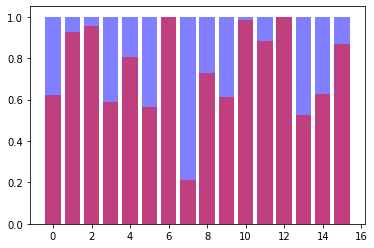

In [35]:
stat= "far"
method = "adversarially_mixed"
averages = np.zeros(16)
original_averages = np.zeros(16)
for results_dict in total_results:
    for i, d in enumerate(results_dict[0][method]):
        original_averages[i] += d[stat]  /5
    for i, d in enumerate(results_dict[1][method]):
        averages[i] += d[stat] /5
print(averages)
print(sum(averages) / 16)

plt.bar(range(16), original_averages, alpha=0.5, color="blue")
plt.bar(range(16), averages, alpha=0.5 ,color="red")

In [4]:

with open("data/stats/Gen/TSTR_auth_DL.pickle", "rb") as file:
    results_dict_DL = pickle.load(file)

with open("data/stats/Gen/TSTR_auth_DL_v2.pickle", "rb") as file:
    results_dict_WA = pickle.load(file)

In [15]:

results_dict = results_dict_WA
stat= "accuracy"
method="self_mixed"
total = 0
print("original")
for d in results_dict[0][method]:
    #print(d.keys())
    total += d[stat] / 16
print(total)
for method in ["same_user_other_gestures_terminal=345", "self_mixed", "just_sampled", "adversarially_mixed"]:
    total = 0
    print(method)
    for d in results_dict[1][method]:
        total += d[stat] / 16
    print(total)

original
0.9160714285714285
same_user_other_gestures_terminal=345
0.8381336405529953
self_mixed
0.938594470046083
just_sampled
0.9380760368663595
adversarially_mixed
0.9390552995391706


In [ ]:
results_dict = [{},{}]

real_gestures_allowed_per_terminal = 2 # 2

legal_terminals = [3,4,5,6,7,8,9] # 

model_handle = "vae_final_10"  #f"wae_lbkeogh_mod_beta=0.0001_lsauth_10"

for method in ["self_mixed", "just_sampled", "adversarially_mixed", "same_user_other_gestures_terminal=345"]:
    results_dict[0][method] = [{} for i in range(16)]
    results_dict[1][method] = [{} for i in range(16)] 
    for auth_user in range(16):
        print(auth_user)

        test_x = x_data[test_gesture_map==1]
        test_y = (y_user.argmax(axis=1) == auth_user)[test_gesture_map==1]

        generated_data_handle = f"data/generated_samples/user={auth_user}_model={model_handle}_method={method}.npy"
        generated_non_user_data_handle = f"data/generated_samples/user={auth_user}_model={model_handle}_non_user.npy"

        real_gesture_list = []

        for terminal_type in legal_terminals:

            legal_gestures = x_data[(train_gesture_map==1) & (y_user.argmax(axis=1) == auth_user) & (y_gesture.argmax(axis=1) == terminal_type) ]

            real_gesture_list.append(legal_gestures[:real_gestures_allowed_per_terminal])

        real_gestures = np.concatenate(real_gesture_list)
        
        train_data_ones = np.load(generated_data_handle)
        
        train_data_ones = np.concatenate([train_data_ones, real_gestures,  real_gestures,  real_gestures,  real_gestures, real_gestures])
        train_data_zeros = np.load(generated_non_user_data_handle)
        train_data_x = np.concatenate([train_data_ones, train_data_zeros])
        train_data_y = np.concatenate([np.ones(len(train_data_ones)), np.zeros(len(train_data_zeros))])

        new_scaler = CustomScaler()
        new_scaler.CHANNELS = 6
        new_data_x = new_scaler.fit_and_transform(train_data_x)
        new_data_y = train_data_y

       

        old_data_x = np.concatenate([real_gestures, x_data[(train_gesture_map == 1) & (y_user.argmax(axis=1) != auth_user)]])
        old_data_y = np.concatenate([np.ones(len(real_gestures)), np.zeros(len(x_data[(train_gesture_map == 1) & (y_user.argmax(axis=1) != auth_user)]))])


        old_scaler = CustomScaler()
        old_scaler.CHANNELS = 6
        old_data_x = old_scaler.fit_and_transform(old_data_x)

        #print("Old data")
        old_model = get_complex_mix_model()
        old_model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

        np.random.seed(1)
        classification_kFold = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)  # tODO _ bug in other code?
        classification_val_map = next(classification_kFold.split(old_data_x, old_data_y))[1]

        classification_val_map_all = np.zeros(len(old_data_x))
        classification_val_map_all[classification_val_map] = 1
        classification_val_map = classification_val_map_all == 1

        early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', start_from_epoch=10,
                                                                   patience=25, restore_best_weights=True)

        history = old_model.fit(old_data_x[~classification_val_map], old_data_y[~classification_val_map], epochs=300,
                                batch_size=32, verbose=0,
                                validation_data=(old_data_x[classification_val_map], old_data_y[classification_val_map]),
                           callbacks=[early_stopping_callback],
                               class_weight = {0:1, 1:15 * 40})

        output = np.squeeze(old_model(old_scaler.transform(test_x)))
        pred = np.squeeze(output > 0.5)
        results_dict[0][method][auth_user] = show_evaluate_model(test_y, pred, output, verbose=1)
        old_model = None
        del old_model

        #########################################

        vae = WAE(None, None, None, None, scale_included=True)
        vae.load_model("Gen", model_handle)

        classification_kFold = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)  # TODO _ bug in other code?
        classification_val_map = next(classification_kFold.split(new_data_x, new_data_y))[1]

        classification_val_map_all = np.zeros(len(new_data_x))
        classification_val_map_all[classification_val_map] = 1
        classification_val_map = classification_val_map_all == 1

        #print("New data")
        new_model = get_complex_mix_model()
        new_model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))


        early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', start_from_epoch=10,
                                                                   patience=25, restore_best_weights=True)

        history = new_model.fit(new_data_x[~classification_val_map], new_data_y[~classification_val_map], epochs=300,
                                batch_size=32, verbose=0,
                                validation_data=(new_data_x[classification_val_map], new_data_y[classification_val_map]),
                           callbacks=[early_stopping_callback],
                               class_weight = {1: 100.0/len(train_data_zeros), 0:100.0/len(train_data_zeros)})

        output = np.squeeze(new_model(new_scaler.transform(test_x)))
        pred = np.squeeze(output > 0.5)
        results_dict[1][method][auth_user] = show_evaluate_model(test_y, pred, output, verbose=0)

        with open("data/stats/Gen/TSTR_auth_final_DL_vaes.pickle", "wb") as file:
            pickle.dump(results_dict, file)
    
with open("data/stats/Gen/TSTR_auth_final_DL_vaes.pickle", "wb") as file:
    pickle.dump(results_dict, file)

new_model = None
del new_model

results_dict


0


In [10]:
results_dict

[{'self_mixed': [{'fmeasure': 0.768,
    'auroc': 0.9902209843290891,
    'eer_theta': 0.0025846371,
    'eer': 0.029382957884427033,
    'frr_at_eer': 0.03125,
    'far_theta': 0.0008402822,
    'far': 0.09990205680705191,
    'frr_at_zero_frr': 0.0,
    'accuracy': 0.9732718894009217},
   {'fmeasure': 0.39215686274509803,
    'auroc': 0.8721788617886178,
    'eer_theta': 0.00076596934,
    'eer': 0.2029268292682927,
    'frr_at_eer': 0.21666666666666667,
    'far_theta': 0.0006591097,
    'far': 0.8702439024390244,
    'frr_at_zero_frr': 0.0,
    'accuracy': 0.9428571428571428},
   {'fmeasure': 0.13592233009708737,
    'auroc': 0.6428948419491041,
    'eer_theta': 0.0038111778,
    'eer': 0.3690944881889764,
    'frr_at_eer': 0.391304347826087,
    'far_theta': 0.0030696634,
    'far': 0.9724409448818898,
    'frr_at_zero_frr': 0.0,
    'accuracy': 0.9179723502304148},
   {'fmeasure': 0.136986301369863,
    'auroc': 0.8916011064410676,
    'eer_theta': 0.015382644,
    'eer': 0.20368

In [10]:
import pickle
#with open("data/stats/Gen/TSTR_intent_part_2.pickle", "wb") as file:
#    pickle.dump(results_dict, file)
#results_dict


In [48]:
"""data/stats/Gen/TSTR_intent_WatchAuth.pickle"""
"""with open("data/stats/Gen/TSTR_intent_WatchAuth.pickle", "rb") as file:
    results_dict1 = pickle.load(file)

results_dict1"""

{'original': {'fmeasure': 0.9615745079662606,
  'auroc': 0.9893363630571896,
  'eer_theta': 0.48,
  'eer': 0.03870967741935484,
  'frr_at_eer': 0.041474654377880185,
  'far_theta': 0.13,
  'far': 0.9935483870967742,
  'frr_at_zero_frr': 0.0009216589861751152,
  'accuracy': 0.9622119815668203},
 'naive_autoencoder_mse_10': {'fmeasure': 0.9601126231816048,
  'auroc': 0.9886151755186986,
  'eer_theta': 0.47,
  'eer': 0.04055299539170507,
  'frr_at_eer': 0.04331797235023042,
  'far_theta': 0.14,
  'far': 0.9935483870967742,
  'frr_at_zero_frr': 0.0009216589861751152,
  'accuracy': 0.9608294930875576},
 'naive_autoencoder_lbkeogh_10': {'fmeasure': 0.9773880941393631,
  'auroc': 0.9947805219902737,
  'eer_theta': 0.51,
  'eer': 0.02119815668202765,
  'frr_at_eer': 0.023963133640552997,
  'far_theta': 0.25,
  'far': 0.6820276497695853,
  'frr_at_zero_frr': 0.0009216589861751152,
  'accuracy': 0.9774193548387097},
 'naive_autoencoder_lbkeogh_mod_10': {'fmeasure': 0.9783310281235593,
  'auroc':

In [6]:
## Doing WatchAuth instead...


real_gestures_allowed_per_terminal = 7

legal_terminals = [3,4] #,5,6,7,8,9]

model_handle = "vae_final_10" #wae_final_10      #f"wae_lbkeogh_mod_beta=0.0001_lsauth_10"

total_results = []

for rep in range(1):
    print("\nrep", rep)

    results_dict = [{},{}]

    vae = WAE(None, None, None, None, scale_included=True)

    for method in ["same_user_other_gestures_terminal=345", "self_mixed", "just_sampled", "adversarially_mixed"]:
        results_dict[0][method] = [{} for i in range(16)]
        results_dict[1][method] = [{} for i in range(16)]  
        for auth_user in range(16):

            print(auth_user, end=' ')

            test_x = x_data[test_gesture_map==1]
            test_y = (y_user.argmax(axis=1) == auth_user)[test_gesture_map==1]

            generated_data_handle = f"data/generated_samples/user={auth_user}_model={model_handle}_method={method}.npy"
            generated_non_user_data_handle = f"data/generated_samples/user={auth_user}_model={model_handle}_non_user.npy"

            real_gesture_list = []

            for terminal_type in legal_terminals:

                legal_gestures = x_data[(train_gesture_map==1) & (y_user.argmax(axis=1) == auth_user) & (y_gesture.argmax(axis=1) == terminal_type) ]

                real_gesture_list.append(legal_gestures[:real_gestures_allowed_per_terminal])

            real_gestures = np.concatenate(real_gesture_list)

            train_data_ones = np.load(generated_data_handle)
            train_data_ones = np.concatenate([train_data_ones, real_gestures]) # weighting had no effect 
            train_data_zeros = np.load(generated_non_user_data_handle)
            train_data_x = np.concatenate([train_data_ones, train_data_zeros])
            train_data_y = np.concatenate([np.ones(len(train_data_ones)), np.zeros(len(train_data_zeros))])

            new_scaler = CustomScaler()
            new_scaler.CHANNELS = 6
            new_data_x = new_scaler.fit_and_transform(train_data_x)
            new_data_x = vae.vae_featurize(new_data_x)

            new_data_y = train_data_y



            old_data_x = np.concatenate([real_gestures, x_data[(train_gesture_map == 1) & (y_user.argmax(axis=1) != auth_user)]])
            old_data_y = np.concatenate([np.ones(len(real_gestures)), np.zeros(len(x_data[(train_gesture_map == 1) & (y_user.argmax(axis=1) != auth_user)]))])


            old_scaler = CustomScaler()
            old_scaler.CHANNELS = 6
            old_data_x = old_scaler.fit_and_transform(old_data_x)

            old_data_x = vae.vae_featurize(old_data_x)

            #print("Old data")
            model = RandomForestClassifier(n_estimators = 100, random_state = rep, class_weight="balanced").fit(old_data_x, old_data_y)
            pred = model.predict(vae.vae_featurize(old_scaler.transform(test_x)))
            output = model.predict_proba(vae.vae_featurize(old_scaler.transform(test_x)))[:, 1]

            results_dict[0][method][auth_user] = show_evaluate_model(test_y, pred, output, verbose=0)
            old_model = None
            del old_model

            #########################################

            vae = WAE(None, None, None, None, scale_included=True)
            #vae.load_model(f"Gen/user={auth_user}", model_handle)


            #print("New data")
            model = RandomForestClassifier(n_estimators = 100, random_state = rep, class_weight="balanced").fit(new_data_x, new_data_y)
            pred = model.predict(vae.vae_featurize(new_scaler.transform(test_x)))
            output = model.predict_proba(vae.vae_featurize(new_scaler.transform(test_x)))[:, 1]
            results_dict[1][method][auth_user] = show_evaluate_model(test_y, pred, output, verbose=0)
        
    total_results.append(results_dict)


#with open("data/stats/Gen/TSTR_auth_final_WatchAuth_repeated_waes.pickle", "wb") as file:
#    pickle.dump(total_results, file)



rep 0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

In [15]:
with open("data/stats/Gen/TSTR_auth_final_WatchAuth_repeated_waes.pickle", "wb") as file:
    pickle.dump(total_results, file)

In [30]:
stat= "far"
total = 0
print("original")
for d in results_dict[0][method]:
    total += d[stat] / 16
print(total)
for method in ["same_user_other_gestures_terminal=345", "self_mixed", "just_sampled", "adversarially_mixed"]:
    total = 0
    print(method)
    for d in results_dict[1][method]:
        total += d[stat] / 16
    print(total)

original
1.0
same_user_other_gestures_terminal=345
0.6837774984196641
self_mixed
0.7646414372554549
just_sampled
0.8367830151985375
adversarially_mixed
0.7917960864659821


In [39]:
import pickle
with open("data/stats/Gen/TSTR_intent_WatchAuth.pickle", "wb") as file:
    pickle.dump(results_dict, file)

In [3]:
def get_complex_mix_model():

    input_dim = (200,6)
    
    inputs = keras.Input(shape=input_dim)
    x = inputs
    y = inputs
    
    
    
    last_output_channels = 22
    for a in range(4):
        x0 = Conv1D(last_output_channels, 1, strides=1, padding="same", activation="relu")(x)
        x1 = Conv1D(last_output_channels, 3, strides=1, padding="same", activation="relu")(x)
        x2 = Conv1D(last_output_channels, 5, strides=1, padding="same", activation="relu")(x)
        x3 = Conv1D(last_output_channels, 10, strides=1, padding="same", activation="relu")(x)
        x0 = MaxPooling1D(pool_size=2, strides=None, padding="same")(x0)
        x1 = MaxPooling1D(pool_size=2, strides=None, padding="same")(x1)
        x2 = MaxPooling1D(pool_size=2, strides=None, padding="same")(x2)
        x3 = MaxPooling1D(pool_size=2, strides=None, padding="same")(x3)
        x = layers.Concatenate()([x0,x1,x2,x3])
        
        x = layers.TimeDistributed(Dense(30, activation="relu"))(x) # , kernel_regularizer=keras.regularizers.L1(1e-4)))(x) # 
        
        
    x = layers.GRU(32, return_sequences=True)(x)
    x = layers.GRU(32, return_sequences=True)(x)
    x = layers.GRU(32)(x)

    x = Dense(25, activation="relu")(x)
    x = Dense(10, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    out = x

    model = keras.Model(inputs, out, name="complex_conv_GRU_classifier")
    
    return model

In [4]:
def get_eer(scores_legit, scores_adv):
    scores_legit = sorted(scores_legit)
    scores_adv = sorted(scores_adv)

    unique_scores_legit = sorted(set(scores_legit))
    
    #treat each legitimate sample distance as a possible threshold, determine the point where FRR crosses FAR
    for c, threshold in enumerate(unique_scores_legit):
        frr = sum(1 if x < threshold else 0 for x in scores_legit) / len(scores_legit)
        far = sum(1 if x >= threshold else 0 for x in scores_adv) / len(scores_adv)
        if frr >= far:
            return threshold, far, frr
    print("Failure")

def get_far_when_zero_frr(scores_legit, scores_adv):
    scores_legit = sorted(scores_legit)
    scores_adv = sorted(scores_adv)

    unique_scores_legit = sorted(set(scores_legit))
    
    last_far = 1.0
    last_frr = 0.0
    last_threshold = 0.0
    
    #treat each legitimate sample distance as a possible threshold, determine the point with the lowest FAR that satisfies the condition that FRR = 0
    for c, threshold in enumerate(unique_scores_legit):
        frr = sum(1 if x < threshold else 0 for x in scores_legit) / len(scores_legit)
        far = sum(1 if x >= threshold else 0 for x in scores_adv) / len(scores_adv)
        if frr > 0.001:
            return last_threshold, last_far, last_frr
        last_far = far
        last_frr = frr
        last_threshold = threshold

scores_legit = [i / 100 for i in range(30,101)]
scores_adv = [i / 100 for i in range(5, 85)]
display(get_eer(scores_legit, scores_adv))
display(get_far_when_zero_frr(scores_legit, scores_adv))

(0.56, 0.3625, 0.36619718309859156)

(0.3, 0.6875, 0.0)

In [5]:
def show_evaluate_model(labels_test, labels_pred, labels_scores, verbose = 1):
    

    fmeasure = f1_score(labels_test, labels_pred, average = "binary", labels = np.unique(labels_pred)) 
    auroc = sklearn.metrics.roc_auc_score(labels_test, labels_scores, labels = np.unique(labels_pred))

    scores_legit = [labels_scores[i] for i in range(len(labels_test)) if 1 == labels_test[i]]
    scores_adv = [labels_scores[i] for i in range(len(labels_test)) if 0 == labels_test[i]]

    eer_theta, eer, frr_at_eer = get_eer(scores_legit, scores_adv)
    far_theta, far, frr_at_zero_frr = get_far_when_zero_frr(scores_legit, scores_adv)
    
    if verbose:
        plt.hist(labels_scores, bins=100)
        plt.show()
        print(f"F1 score        : {fmeasure}")
        print(f"AUROC           : {auroc}")
        print(f"EER             : {eer}")
        print(f"frr_at_eer      : {frr_at_eer}")
        print(f"far at zero frr : {far}")
        print(f"frr at 'zero' frr : {frr_at_zero_frr}")

    accuracy = sum(labels_test == labels_pred) / len(labels_test)
    
    return {"fmeasure":fmeasure, "auroc":auroc, "eer_theta":eer_theta, "eer":eer, "frr_at_eer":frr_at_eer, 
            "far_theta":far_theta, "far":far, "frr_at_zero_frr":frr_at_zero_frr, "accuracy":accuracy}